# PART 1

## 1 Assimilate the business scenario and articulate testable hypotheses
- Take what you have read from the stories and from what you know about the business scenario and, in your own words, carefully re-state the business opportunity. Given the stated opportunity, enumerate the testable hypotheses.

The business opportunity is centered around extracting what countries that show the biggest potential and the optimization of ROI. According to the description "They have asked you to create a service that, at any point in time, will predict the revenue for the following month. They have also asked that the service be given the ability to project revenue for a specific country... well-projected numbers will help stabilize staffing and budget projections which will have a beneficial ripple effect throughout the company." 

I guess that means the data is collected with the new a la carté system in place. So we should train a model based on this data, then use it to predict future revenue for other countries that haven't tried the system yet etc. 

    

## State the ideal data to address the business opportunity and clarify the rationale for needing specific data.
- Note that this step is carried out **before you read in the data**.  It helps clarify exactly what your are looking for in the data and it helps provide context for what the feature matrix and targets will look like.

We need the country, user_id, sales, time to start with. 

## 3. Create a python script to extract relevant data from multiple data sources, automating the process of data ingestion.

- From within a Python module there should be a function that reads in the data, attempts to catch common input errors and returns a feature matrix (NumPy array or Pandas DataFrame) that will subsequently be used as a starting point for EDA and modeling.



In [2]:
import os
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt

In [3]:
train_data = './data/cs-train'
test_data = './data/cs-production'

In [4]:
data_dir = train_data
## input testing
if not os.path.isdir(data_dir):
    raise Exception("specified data dir does not exist")
if not len(os.listdir(data_dir)) > 0:
    raise Exception("specified data dir does not contain any files")

##extract the whole path for each invoice 
file_list = [os.path.join(data_dir,f) for f in os.listdir(data_dir) if re.search("\.json",f)]

## read data into a temp structure
all_months = {}
for file_name in file_list:
    df = pd.read_json(file_name)
    ## take the tail as key
    all_months[os.path.split(file_name)[1]] = df

In [5]:
first5pairs = {k: all_months[k] for k in list(all_months)[:5]}
print(first5pairs)

{'invoices-2018-01.json':               country  customer_id invoice  total_price StreamID  TimesViewed  \
0      United Kingdom      15581.0  493463         2.95    20895            1   
1      United Kingdom      15581.0  493463         1.25    20866            1   
2      United Kingdom      15581.0  493463         0.85    85198           12   
3      United Kingdom      15581.0  493463         2.95    20897            1   
4      United Kingdom      15581.0  493463         2.95    20898            1   
...               ...          ...     ...          ...      ...          ...   
35677  United Kingdom      13553.0  496651         5.95    20689            1   
35678  United Kingdom      13553.0  496651         7.95    82486            2   
35679  United Kingdom      13553.0  496651        12.75   47581B            1   
35680  United Kingdom      13553.0  496651         0.29    21986           12   
35681  United Kingdom      13553.0  496651         2.55    20828            4   

 

In [6]:
# tip1: The JSON files may not contain uniformly named features. Be sure to account for this in your data ingestion function.
## ensure the data are formatted with correct columns
correct_columns = ['country', 'customer_id', 'day', 'invoice', 'month','price', 'stream_id', 'times_viewed', 'year']

for f,df in all_months.items():
    cols = set(df.columns.tolist())
    if 'StreamID' in cols:
         df.rename(columns={'StreamID':'stream_id'},inplace=True)
    if 'TimesViewed' in cols:
        df.rename(columns={'TimesViewed':'times_viewed'},inplace=True)
    if 'total_price' in cols:
        df.rename(columns={'total_price':'price'},inplace=True)

    cols = df.columns.tolist()
    if sorted(cols) != correct_columns:
        print(cols)
        raise Exception("columns name could not be matched to correct cols")

In [7]:
## merge all dict values into one df
df = pd.concat(list(all_months.values()),sort=True)


In [8]:
## tip 2: One common way to ready time-series data for modeling is to aggregate the transactions by day. Getting the data into this form will help you prepare for part 2.
## merge time column 
years,months,days = df['year'].values,df['month'].values,df['day'].values 

# add zeros to months and days with only one digit 
dates = ["{}-{}-{}".format(years[i],str(months[i]).zfill(2),str(days[i]).zfill(2)) for i in range(df.shape[0])]
df['invoice_date'] = np.array(dates,dtype='datetime64[D]')

In [9]:
##Some of the invoice ids (invoice) have letters that can be removed to improve matching.
## regex expression \d replace all digits and \D all letters, t.ex 84659A
display(df.iloc[20])
df['invoice'] = [re.sub("\D+","",i) for i in df['invoice'].values]

country              United Kingdom
customer_id                   16296
day                               1
invoice                     C493445
month                             1
price                          2.55
stream_id                    84659A
times_viewed                      2
year                           2018
invoice_date    2018-01-01 00:00:00
Name: 20, dtype: object

In [10]:
## sort by date and reset the index
df.sort_values(by='invoice_date',inplace=True)
df.reset_index(drop=True,inplace=True)

In [11]:
df.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,17998.0,28,489562,11,5.95,84656,1,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


## 4. Investigate the relationship between the relevant data, the target and the business metric.

- Using the feature matrix and the tools abvailable to you through EDA spend some time to get to know the data.



In [12]:
print(df.describe())

         customer_id            day          month          price  \
count  625249.000000  815011.000000  815011.000000  815011.000000   
mean    15333.415068      15.064819       6.592718       4.802631   
std      1698.360788       8.788845       3.598781     135.058707   
min     12346.000000       1.000000       1.000000  -53594.360000   
25%     13956.000000       7.000000       3.000000       1.250000   
50%     15279.000000      15.000000       6.000000       2.100000   
75%     16813.000000      23.000000      10.000000       4.210000   
max     18287.000000      31.000000      12.000000   38970.000000   

        times_viewed           year  
count  815011.000000  815011.000000  
mean        5.231106    2018.247654  
std         5.109982       0.545261  
min         0.000000    2017.000000  
25%         1.000000    2018.000000  
50%         3.000000    2018.000000  
75%         8.000000    2019.000000  
max        24.000000    2019.000000  


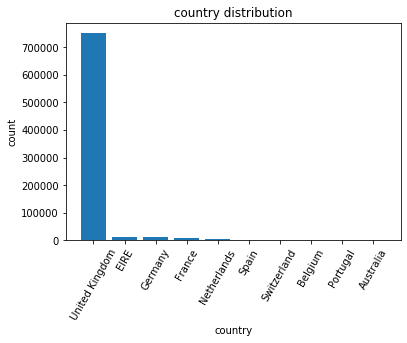

In [29]:
##Check country distribution
count = df['country'].value_counts()[:10]
invoice_country = count.index
plt.bar(invoice_country, count)
plt.title('country distribution')
plt.xlabel('country')
plt.ylabel('count')
plt.xticks(rotation=60)
plt.show()

In [70]:
##Check null occurences
display(df.isna().sum())

country              0
customer_id     189762
day                  0
invoice              0
month                0
price                0
stream_id            0
times_viewed         0
year                 0
invoice_date         0
dtype: int64

In [54]:
## check starting and ending period
print("invoice start:", df.invoice_date.min(),"invoice last", df.invoice_date.max())

invoice start: 2017-11-28 00:00:00 invoice last 2019-07-31 00:00:00


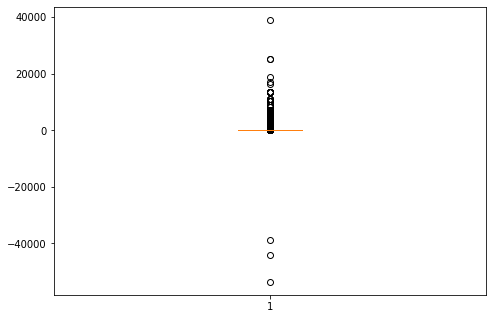

In [14]:
fig = plt.figure()
# Create an axes instance
ax = fig.add_axes([0,0,1,1])
# Create the boxplot
bp = ax.boxplot(df['price'])
plt.show()

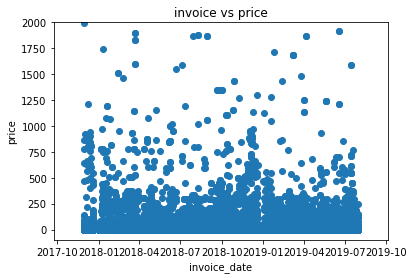

In [34]:
plt.scatter(df['invoice_date'], df['price'])
plt.title('invoice vs price')
plt.xlabel('invoice_date')
plt.ylabel('price')
plt.ylim(-100, 2000)
plt.show()

NameError: name 'x' is not defined

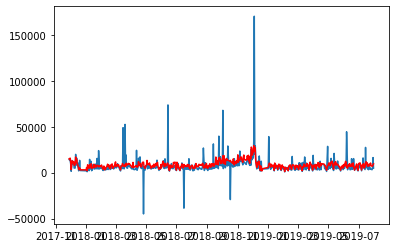

In [72]:

group_df = df.groupby('invoice_date',as_index=False)[['price','times_viewed']].agg({'price':'sum','times_viewed':'sum'})
plt.plot(group_df["invoice_date"],group_df['price'])
plt.plot(group_df["invoice_date"],group_df['times_viewed'],color="r"),

#plt.show()

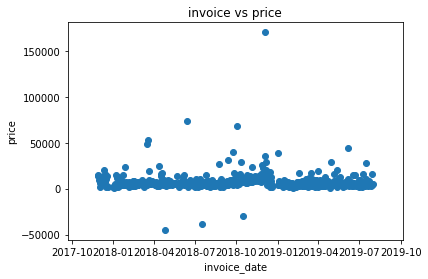

In [53]:
group_df = df.groupby('invoice_date',as_index=False).agg({'price':'sum'})
plt.scatter(agg_df['invoice_date'], agg_df['price'])
plt.title('invoice vs price')
plt.xlabel('invoice_date')
plt.ylabel('price')
#plt.ylim(-100, 2000)
plt.show()

## 5. Articulate your findings using a deliverable with visualizations.

- Summarize what you have learned in your investigations using visualizations.

The data is highly skewed towards United_kingdom and a big majority of the prices fall in the range of 0-500. There seem to be some correlation between number of times viewed and the prices during a invoice period.